In [1]:
# setup
import os
import torch
import torchvision

import numpy as np
import matplotlib as plt


# local utils
# !find . -name \*.pyc -delete
from vis_utils import *
from model_def import *
from model_train import *


%matplotlib inline

## Make GIF
# convert -delay 5 -loop 0 `ls -v` ../gif_of_conv-filters_same-init.gif

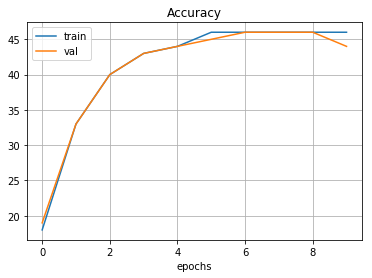

In [4]:
# Load training logs from a completed experiment and plot the accuracy curve
expName = 'cifar-MLP_v6.0.4'
expDir = os.path.join('./data', expName)
a = np.loadtxt(os.path.join(expDir, 'net-accu-train.log'))
b = np.loadtxt(os.path.join(expDir, 'net-accu-val.log'))
f = plot_epoch_perf(a, b)


10
20
30
40
50
60
70
80
90
100
110
120
130
140
150


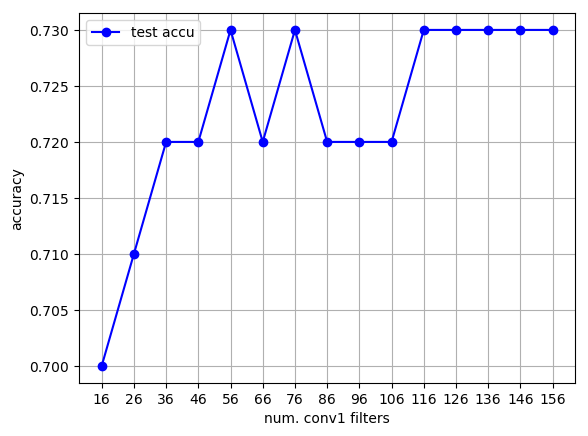

In [65]:
# Plot CIFAR-10 test accuracy versus increasing number of conv1 filters

numFilter = range(10,151,10) # filters added to the original 6 in conv1 for LeNet-5
testAccu = []
weightSimil = []

for _,i in enumerate(numFilter):
    
    expFolder = os.path.join('data', 'cifar-lenet-widen-'+str(i)+'-01')
#     print expFolder
    
    # CIFAR-10 test accuracy
    dat = np.loadtxt(os.path.join(expFolder, 'result-train-test.txt'))
    testAccu = np.append(testAccu, dat[1]/100)
    
    # Similarity of conv1 filters
    
    # load network
    modelPath = os.path.join(expFolder, 'net-trained.dat')
    net = NetWide(i)
    net.load_state_dict(torch.load(modelPath))
    
    # similarity of conv1 filters
    conv1Params = list(net.conv1.parameters())
    w = conv1Params[0]
    wSimil, _ = weightCovar(w, do_abs=True)
    weightSimil = np.append(weightSimil, wSimil.data.numpy())
#     print 'Cosine similarity: '+str(wSimil.data.numpy())
  

nf = np.add(numFilter,6)
f = plt.figure()
plt.plot(nf, testAccu, 'bo-', label='test accu')
plt.xlabel('num. conv1 filters')
plt.ylabel('accuracy')
plt.xticks(nf)
plt.grid()
plt.legend()
f.savefig(os.path.join('./data', 'figures', 'cifar_lenet_16-46_simil-matrix','cifar_accuracy_16-156.png'), bbox_inches='tight')


10
20
30
40
50
60
70
80
90
100
110
120
130
140
150


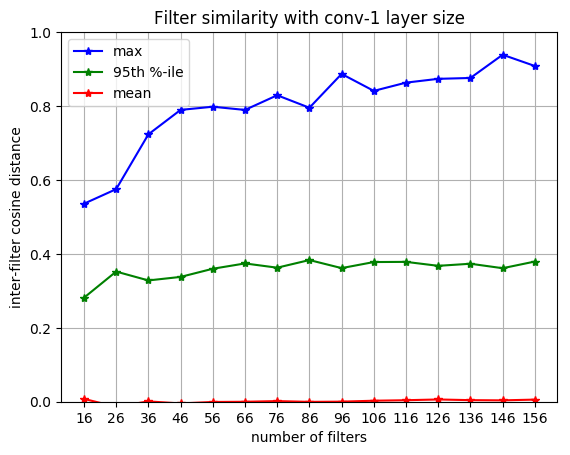

In [142]:
# Plot Conv1 similarity matrix and cosine-distance between filters

numFilter = range(10,151,10) # filters added to the original 6 in conv1 for LeNet-5
# weightSimilMat = []
maxSimil = []
meanSimil = []
prcntSimil = []

outDir = os.path.join('./data', 'figures', 'cifar_lenet_16-46_simil-matrix')
if not os.path.exists(outDir):
    os.makedirs(outDir)

for idx,i in enumerate(numFilter):
    
    expFolder = os.path.join('data', 'cifar-lenet-widen-'+str(i)+'-01')
    
    # Similarity of conv1 filters
    
    # load network
    modelPath = os.path.join(expFolder, 'net-trained.dat')
    net = NetWide(i)
    net.load_state_dict(torch.load(modelPath))
    
    # get similarity matrix of conv1 filters
    conv1Params = list(net.conv1.parameters())
    w = conv1Params[0]
    wSimil, wSimilMat = weightCovar(w, do_abs=False) # do not penalize negative correlations
    similMat = wSimilMat.data.numpy()
    
    
    fig = plt.figure()
    # show the similarity matrix
    plt.imshow(similMat)
    plt.title('similarity matrix')
    plt.colorbar()
    plt.tight_layout()
    fig.savefig(os.path.join(outDir, 'simil-mat-'+str(i)+'.png'), bbox_inches='tight')
    plt.close()
    
    # show lower off-diagonal entries matrix
    fig = plt.figure()
    similMatOffdiag = np.tril(similMat,k=-1)
    plt.imshow(similMatOffdiag)
    plt.title('Off-diag')
    plt.colorbar()
    plt.tight_layout()
    fig.savefig(os.path.join(outDir, 'simil-offdiag-mat-'+str(i)+'.png'), bbox_inches='tight')
    plt.close()
    
    # Energies of off-diagonal entries
    # fk, axarr = plt.subplots(nrows=3,ncols=1)
    sz = similMat.shape
    idxOffdiag = np.tril_indices(sz[0],k=-1) # lower triangular matrix below diagonal
    valOffdiag = similMatOffdiag[idxOffdiag]
    #print valOffdiag.shape
    maxOffdiag = np.max(valOffdiag)
    percentileOffdiag = np.percentile(valOffdiag,95)
    meanOffdiag = np.mean(valOffdiag)
    #print 'Max off-diag:' + str(maxOffdiag)
    #print 'Mean off-diag:' + str(meanOffdiag)
    #print '95-th percentile:' + str(percentileOffdiag)
    maxSimil = np.append(maxSimil, maxOffdiag)
    meanSimil = np.append(meanSimil, meanOffdiag)
    prcntSimil = np.append(prcntSimil, percentileOffdiag)

    
# plotting
f = plt.figure()
nf = np.add(numFilter,6.0)
plt.plot(nf, maxSimil, 'b*-', label='max')
plt.plot(nf, prcntSimil, 'g*-', label='95th %-ile')
plt.plot(nf, meanSimil, 'r*-', label='mean')
plt.xlabel('number of filters')
plt.ylabel('inter-filter cosine distance')
plt.xticks(nf)
plt.title('Filter similarity with conv-1 layer size')
plt.ylim(0.0, 1.0)
plt.grid()
plt.legend()
f.savefig(os.path.join(outDir, 'simil-numfilters-16-156.png'), bbox_inches='tight')
    
    
    

data/cifar-lenet-widen-140-01
140
data/cifar-lenet-widen-150-01
150


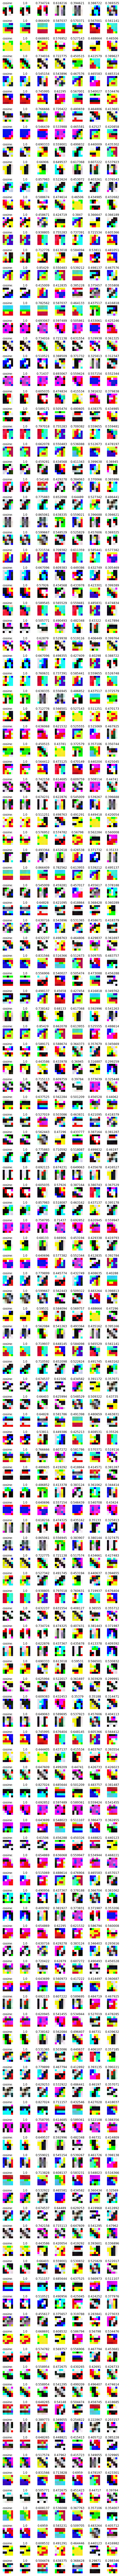

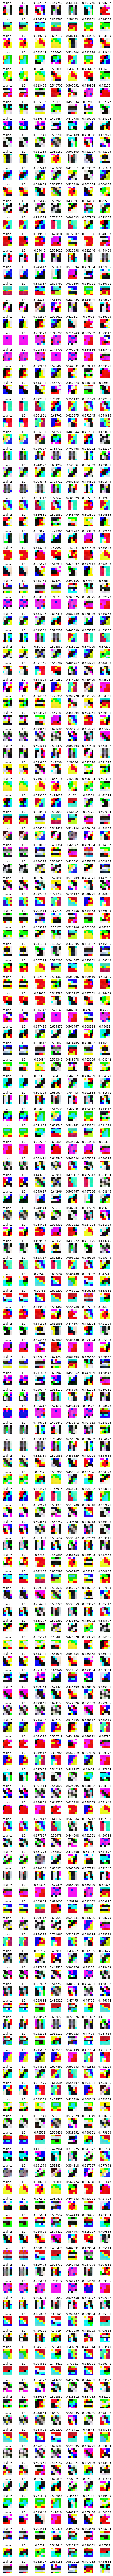

In [17]:
# Plot top-k most similar filters for each filter in conv1 layer

K = 6
numFilter = [140, 150]

outDir = os.path.join('./data', 'figures', 'cifar_lenet_16-46_simil-matrix')
if not os.path.exists(outDir):
    os.makedirs(outDir)
    
for idx,i in enumerate(numFilter):
    
    expFolder = os.path.join('data', 'cifar-lenet-widen-'+str(i)+'-01')
    print expFolder
    
    # load network
    modelPath = os.path.join(expFolder, 'net-trained.dat')
    net = NetWide(i)
    net.load_state_dict(torch.load(modelPath))
    
    # get similarity matrix of conv1 filters
    conv1Params = list(net.conv1.parameters())
    w = conv1Params[0]
    wSimil, wSimilMat = weightCovar(w)
    similMat = wSimilMat.data.numpy()
    

    # get 'most similar' filters
    sz = similMat.shape
    sortIdx = np.argsort(-similMat, axis=1)  # sort each row by similarity, descending
    subplotCounter = 0
    
    # figure -- one row for each filter:
    #    [filter_1] [nearest filters 1...k]
    #    [filter_2] [nearest filters 1...k]
    #    [filter_3] [nearest filters 1...k]
    #    [ .......] [nearest filters 1...k]
    # f,axarr = plt.subplots(nrows=sz[0],ncols=K+1)
    f = plt.figure(figsize=(K+1,sz[0]))
    
    for j in range(0,sz[0]):
        rowSortedIdx = sortIdx[j] 
        nearestFilterIdx = rowSortedIdx[0:K] # get K elements with largest cosine simlarity
        # print nearestFilterIdx
        # print similMat[j][nearestFilterIdx]
        # print '\n'
        
        # display filter_j
        im = np.transpose(w[j].cpu().data.numpy(), (1, 2, 0))
        ax = f.add_subplot(sz[0],K+1, subplotCounter+1)
        ax.imshow(im)
        subplotCounter = subplotCounter + 1
        ax.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_title('cosine:')
        
        for k in range(0,K):            
            im = np.transpose(w[nearestFilterIdx[k]].cpu().data.numpy(), (1, 2, 0))
            ax = f.add_subplot(sz[0], K+1, subplotCounter+1)
            ax.imshow(im)
            subplotCounter = subplotCounter + 1
            ax.axis('off')
            ax.set_xticklabels([])
            ax.set_yticklabels([])
            ax.set_title(str(similMat[j][nearestFilterIdx[k]]))
    
    plt.tight_layout()
    f.savefig(os.path.join(outDir,'nearest-filters-'+str(i)+'.png'), bbox_inches='tight')
    plt.close(f)
    
    
    

10


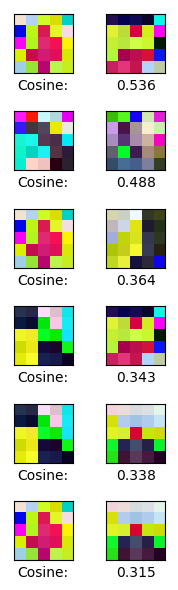

In [166]:
# Plot most similar filter PAIRS (within 95-th percentile of max cosine similarity in a layer)


numFilter = [10]
MAX_PAIRS = 50

outDir = os.path.join('./data', 'figures', 'cifar_lenet_16-46_simil-matrix')
if not os.path.exists(outDir):
    os.makedirs(outDir)
    
for idx,i in enumerate(numFilter):
    
    expFolder = os.path.join('data', 'cifar-lenet-widen-'+str(i)+'-01')
    # print expFolder
    
    # load network
    modelPath = os.path.join(expFolder, 'net-trained.dat')
    net = NetWide(i)
    net.load_state_dict(torch.load(modelPath))
    
    # get similarity matrix of conv1 filters
    similMat, w = get_layer_cosine_similarity(net, 'conv1.weight')

    # get indices and mask array of lower-triangular matrix
    sz = similMat.shape
    offdiagIndices = np.tril_indices(sz[0], k=-1) # below diagonal
    offdiagVal = similMat[offdiagIndices] 
    maskTril = np.zeros(sz, dtype=bool) # boolean array same shape as similMat
    maskTril[offdiagIndices] = True

    # get the 95-th percentile of cosine similarity
    similThresh = np.percentile(offdiagVal, 95)
    maskLargeSimil = np.greater(similMat, similThresh)
    rowId, colId = np.nonzero(maskLargeSimil & maskTril)
    
    # sort these in order of similarity
    similValues = similMat[rowId, colId]
    pairList = zip(similValues.tolist(), rowId.tolist(), colId.tolist() )
    pairList.sort()
    pairList.reverse() # descending
    
    K = np.min([len(pairList), MAX_PAIRS]) # number of filter pairs to display
    
    # figure settings - display closest pairs
    plt.rcParams["figure.figsize"] = (2,K) # (width, height)
    f = plt.figure()
    subplotCounter = 1
    
    for j in range(K):
        
        listItem = pairList[j] # (similarity, rowId, colId)
        
        w1 = w[listItem[1]]
        im1 = np.transpose(w1, (1,2,0))
        ax = f.add_subplot(K,2, subplotCounter)
        ax.imshow(im1)
        subplotCounter += 1
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_xlabel('Cosine:')
        
        w2 = w[listItem[2]]
        im2 = np.transpose(w2, (1,2,0))
        ax = f.add_subplot(K,2, subplotCounter)
        ax.imshow(im2)
        subplotCounter += 1
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xlabel('%.3f' % listItem[0])
    
    # f.suptitle('Closest filter pairs: conv1-'+str(i), fontsize=20)
    plt.tight_layout()
    f.savefig(os.path.join(outDir,'nearest-filter-pairs-' + str(i) + '.png'), bbox_inches='tight')
    # plt.close(f)    
    
    # reset matplotlib figure size to defaults
    plt.rcParams.update(plt.rcParamsDefault)
    
    
    

10
20
30
40
50
60
70
80
90
100
110
120
130
140
150


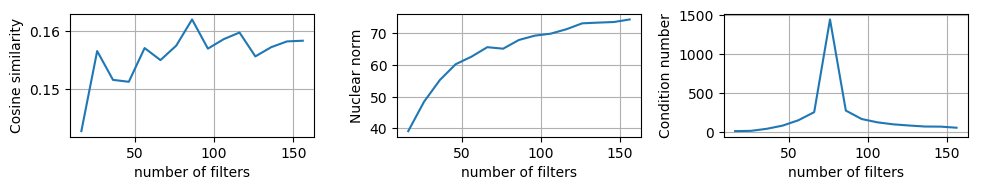

In [162]:
# Rank-deficiency of weight matrix

numFilter = range(10, 151, 10) # filters added to the original 6 in conv1 for LeNet-5
weightSimil = []
nucNormList = []
condList = []

for idx,i in enumerate(numFilter):
    
    expFolder = os.path.join('data', 'cifar-lenet-widen-'+str(i)+'-01')
    # print expFolder
    
    # CIFAR-10 test accuracy
    dat = np.loadtxt(os.path.join(expFolder, 'result-train-test.txt'))
    testAccu = np.append(testAccu, dat[1]/100)
    
    # Similarity of conv1 filters
    
    # load network
    modelPath = os.path.join(expFolder, 'net-trained.dat')
    net = NetWide(i)
    net.load_state_dict(torch.load(modelPath))
    
    # similarity of conv1 filters
    conv1Params = list(net.conv1.parameters())
    w = conv1Params[0]
    wSimil, _ = weightCovar(w, do_abs=True)
    weightSimil = np.append(weightSimil, wSimil.data.numpy())
    # print 'Cosine similarity: '+str(wSimil.data.numpy())
    
    # flatten the W 4-D tensor into a 2-D matrix
    (num_filters,_,_,_) = w.size()
    wMat = w.view(num_filters, -1)
    wMat = wMat.data.numpy()
    print wMat.shape
    
    # nuclear norm
    nucNorm = np.linalg.norm(wMat, ord='nuc')
    nucNormList = np.append(nucNormList, nucNorm)
    # print 'nuclear norm:'+str(nucNorm)
    
    # condition number
    cond = np.linalg.cond(wMat)
    condList = np.append(condList, cond)
    # print 'condition number:'+str(cond) + '\n\n'
    

nf = np.add(numFilter,6)

plt.rcParams["figure.figsize"] = (10,2)
f = plt.figure()

ax = f.add_subplot(1,3,1)
ax.plot(nf, weightSimil, label='cosine')
ax.grid(True)
ax.set_ylabel('Cosine similarity')
ax.set_xlabel('number of filters')

ax = f.add_subplot(1,3,2)
ax.plot(nf, nucNormList, label='nuc norm')
ax.grid(True)
ax.set_ylabel('Nuclear norm')
ax.set_xlabel('number of filters')

ax = f.add_subplot(1,3,3)
ax.plot(nf, condList, label='cond num')
ax.grid(True)
ax.set_ylabel('Condition number')
ax.set_xlabel('number of filters')

plt.tight_layout()

plt.rcParams.update(plt.rcParamsDefault)
# f = plt.figure()
# plt.plot(nf, nucNormList, label='nuc norm')
# plt.plot(nf, condList, label='cond num')
# plt.xlabel('num. conv1 filters')
# plt.xticks(nf)
# plt.grid()
# plt.legend()
# plt.ylim(0, 80)

# f.savefig(os.path.join('./data', 'figures', 'cifar_lenet_16-46_simil-matrix','cifar_accuracy_16-46.png'), bbox_inches='tight')
